# PursuitEvasion16x16-v0 Heuristic experiment analysis 

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "PursuitEvasion16x16-v0", "results", "klr_results_v0.csv"
)
figure_dir = osp.join(
    BASE_REPO_DIR, "experiments", "PursuitEvasion16x16-v0", "figures"
)
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
)

## Define Co-Player Prior

In [4]:
# Uniform
# Note K4 is not in prior 
policy_prior = {
    0: {
        "klr_k0_seed0_i0-v0": 1/4,
        "klr_k1_seed0_i0-v0": 1/4,
        "klr_k2_seed0_i0-v0": 1/4,
        "klr_k3_seed0_i0-v0": 1/4
    },
    1: {
        "klr_k0_seed0_i1-v0": 1/4,
        "klr_k1_seed0_i1-v0": 1/4,
        "klr_k2_seed0_i1-v0": 1/4,
        "klr_k3_seed0_i1-v0": 1/4
    }
}
fixed_policy_ids = list(policy_prior[0]) + list(policy_prior[1]) + ["klr_k4_seed0_i0-v0", "klr_k4_seed0_i1-v0"]
fixed_policy_ids.sort()

# Problem size

- Grid size = 16 x 16
- Num free coods = 145 
- Num goal = 3

**States**

```
= evader_states * pursuer_states 
= (pos * dir * goal * min_goal_dist) * (pos * dir)
= (145 * 4 * 3 * 23) * (145 * 4) 
= 23,211,600
```

**Actions** = 4 (Forward, Backward, Left, Right)

**Observations**

```
= adj_cells * seed * heard * evader_start_coord, pursuer_start_coord * goal_coord
= 2**4 * 2 * 2 * 6 * 2 * 6
= 4,608
```

Coord observations are constant throught an episode so only influence branching for the initial observation.
Given agents know their initial location and the map is fixed and known the branching is `2*2=4`.

## The Environment

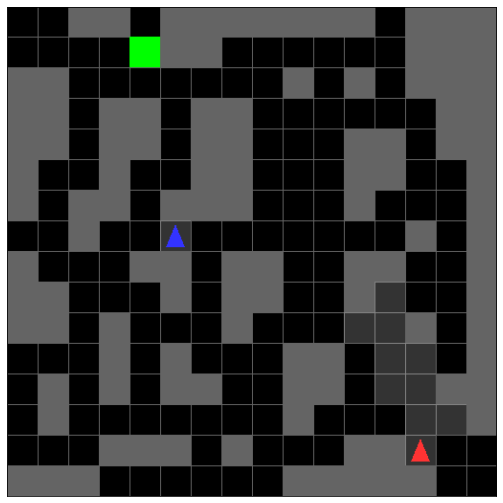

In [5]:
fig, ax = plot_utils.plot_environment("PursuitEvasion16x16-v0", (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Fixed Policy Data

In [6]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("All Fixed Policies")
print("------------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
    
# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]
fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("\nExperiment Fixed Policies")
print("-------------------------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

All Fixed Policies
------------------
   klr_k0_seed0_i0-v0
   klr_k0_seed0_i1-v0
   klr_k0_seed1_i0-v0
   klr_k0_seed1_i1-v0
   klr_k0_seed2_i0-v0
   klr_k0_seed2_i1-v0
   klr_k0_seed3_i0-v0
   klr_k0_seed3_i1-v0
   klr_k0_seed4_i0-v0
   klr_k0_seed4_i1-v0
   klr_k1_seed0_i0-v0
   klr_k1_seed0_i1-v0
   klr_k1_seed1_i0-v0
   klr_k1_seed1_i1-v0
   klr_k1_seed2_i0-v0
   klr_k1_seed2_i1-v0
   klr_k1_seed3_i0-v0
   klr_k1_seed3_i1-v0
   klr_k1_seed4_i0-v0
   klr_k1_seed4_i1-v0
   klr_k2_seed0_i0-v0
   klr_k2_seed0_i1-v0
   klr_k2_seed1_i0-v0
   klr_k2_seed1_i1-v0
   klr_k2_seed2_i0-v0
   klr_k2_seed2_i1-v0
   klr_k2_seed3_i0-v0
   klr_k2_seed3_i1-v0
   klr_k2_seed4_i0-v0
   klr_k2_seed4_i1-v0
   klr_k3_seed0_i0-v0
   klr_k3_seed0_i1-v0
   klr_k3_seed1_i0-v0
   klr_k3_seed1_i1-v0
   klr_k3_seed2_i0-v0
   klr_k3_seed2_i1-v0
   klr_k3_seed3_i0-v0
   klr_k3_seed3_i1-v0
   klr_k3_seed4_i0-v0
   klr_k3_seed4_i1-v0
   klr_k4_seed0_i0-v0
   klr_k4_seed0_i1-v0
   klr_k4_seed1_i0-v0
   klr_k4_seed1_

## Heuristic policies pairwise performance

This is what was used to generate the meta-policies.

In [7]:
fixed_policies_0 = [
    "klr_k0_seed0_i0-v0",
    "klr_k1_seed0_i0-v0",
    "klr_k2_seed0_i0-v0",
    "klr_k3_seed0_i0-v0",
    "klr_k4_seed0_i0-v0"
]
fixed_policies_1 = [
    "klr_k0_seed0_i1-v0",
    "klr_k1_seed0_i1-v0",
    "klr_k2_seed0_i1-v0",
    "klr_k3_seed0_i1-v0",
    "klr_k4_seed0_i1-v0"
]
fixed_policy_labels={
    "klr_k0_seed0_i0-v0": "K0_0",
    "klr_k1_seed0_i0-v0": "K1_0",
    "klr_k2_seed0_i0-v0": "K2_0",
    "klr_k3_seed0_i0-v0": "K3_0",
    "klr_k4_seed0_i0-v0": "K4_0",
    "klr_k0_seed0_i1-v0": "K0_1",
    "klr_k1_seed0_i1-v0": "K1_1",
    "klr_k2_seed0_i1-v0": "K2_1",
    "klr_k3_seed0_i1-v0": "K3_1",
    "klr_k4_seed0_i1-v0": "K4_1",
}

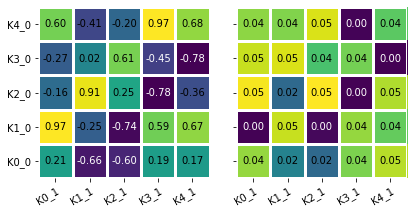

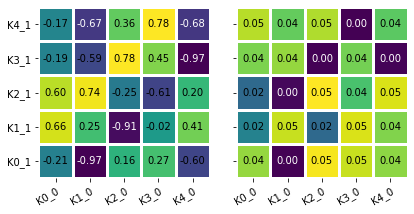

In [8]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_0.png"))

fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_1.png"))

In [9]:
# Get payofss in meta policy dictionary format (for use in experiments)
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    average_duplicates=True,
    duplicate_warning=True
)

for c, col_policy in enumerate(col_policies):
    print(f'(-1, "{col_policy}"):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")
    
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    average_duplicates=True,
    duplicate_warning=True
)


for c, col_policy in enumerate(col_policies):
    print(f'("{col_policy}", -1):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")

(-1, "klr_k0_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.21,
    "klr_k1_seed0_i0-v0": 0.97,
    "klr_k2_seed0_i0-v0": -0.16,
    "klr_k3_seed0_i0-v0": -0.27,
    "klr_k4_seed0_i0-v0": 0.60,
},
(-1, "klr_k1_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.66,
    "klr_k1_seed0_i0-v0": -0.25,
    "klr_k2_seed0_i0-v0": 0.91,
    "klr_k3_seed0_i0-v0": 0.02,
    "klr_k4_seed0_i0-v0": -0.41,
},
(-1, "klr_k2_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.60,
    "klr_k1_seed0_i0-v0": -0.74,
    "klr_k2_seed0_i0-v0": 0.25,
    "klr_k3_seed0_i0-v0": 0.61,
    "klr_k4_seed0_i0-v0": -0.20,
},
(-1, "klr_k3_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.19,
    "klr_k1_seed0_i0-v0": 0.59,
    "klr_k2_seed0_i0-v0": -0.78,
    "klr_k3_seed0_i0-v0": -0.45,
    "klr_k4_seed0_i0-v0": 0.97,
},
(-1, "klr_k4_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.17,
    "klr_k1_seed0_i0-v0": 0.67,
    "klr_k2_seed0_i0-v0": -0.36,
    "klr_k3_seed0_i0-v0": -0.78,
    "klr_k4_seed0_i0-v0": 0.68,
},
("klr_k0_seed0_i0-v0", 

### Add Full-Knowledge Best-Response baseline

In [9]:
# Maps policy_id -> best response policy_id
best_response_map = {
    0: {
        "klr_k0_seed0_i1-v0": "klr_k1_seed0_i0-v0",
        "klr_k1_seed0_i1-v0": "klr_k2_seed0_i0-v0",
        "klr_k2_seed0_i1-v0": "klr_k3_seed0_i0-v0",
        "klr_k3_seed0_i1-v0": "klr_k4_seed0_i0-v0",
        # "klr_k4_seed0_i1-v0": "klr_k4_seed0_i0-v0",
    }, 
    1: {
        "klr_k0_seed0_i0-v0": "klr_k1_seed0_i1-v0",
        "klr_k1_seed0_i0-v0": "klr_k2_seed0_i1-v0",
        "klr_k2_seed0_i0-v0": "klr_k3_seed0_i1-v0",
        "klr_k3_seed0_i0-v0": "klr_k4_seed0_i1-v0",
        # "klr_k4_seed0_i0-v0": "klr_k4_seed0_i1-v0",
    }
}

new_rows = []
for (agent_id, coplayer_agent_id) in [(0, 1), (1, 0)]:
    for coplayer_policy_id, br_policy_id in best_response_map[agent_id].items():
        next_exp_id = policy_df["exp_id"].max() + 1
        br_row = policy_df.loc[
            (policy_df["agent_id"] == agent_id)
            & (policy_df["policy_id"] == br_policy_id) 
            & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
        ].copy()
        br_coplayer_row = policy_df.loc[
            (policy_df["agent_id"] == coplayer_agent_id)
            & (policy_df["exp_id"].isin(br_row["exp_id"]))
        ].copy()
        # update policy id to baseline name
        br_row["policy_id"] = f"full-knowledge-br_i{agent_id}"
        # update exp ids to avoid duplicates
        br_row["exp_id"] = next_exp_id
        br_coplayer_row["exp_id"] = next_exp_id
        new_rows.append(br_row)
        new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"].isin(["full-knowledge-br_i0", "full-knowledge-br_i1"])]

16
16
386


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,time_limit,episode_return_mean,episode_return_std,episode_return_max,...,num_NA,episode_return_CI,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,coplayer_policy_id
370,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965419,0.018966,0.991935,...,0,0.001176,0.272501,0.001036,0.000,0.0,1.000,0.000,0,klr_k0_seed0_i1-v0
372,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.911089,0.296733,0.991935,...,0,0.018392,0.374425,0.001199,0.032,0.0,0.968,0.000,0,klr_k1_seed0_i1-v0
374,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.608452,0.607099,0.991935,...,164,0.037628,1.728013,0.005550,0.122,0.0,0.714,0.164,0,klr_k2_seed0_i1-v0
376,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965653,0.019036,0.991935,...,0,0.001180,0.274766,0.001033,0.000,0.0,1.000,0.000,0,klr_k3_seed0_i1-v0
378,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.663605,0.382248,0.798387,...,0,0.023692,0.257832,0.000837,0.053,0.0,0.947,0.000,0,klr_k0_seed0_i0-v0
380,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.740653,0.028971,0.790323,...,0,0.001796,0.205305,0.000668,0.000,0.0,1.000,0.000,0,klr_k1_seed0_i0-v0
382,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.779145,0.017689,0.806452,...,0,0.001096,0.180085,0.000591,0.000,0.0,1.000,0.000,0,klr_k2_seed0_i0-v0
384,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.777556,0.012517,0.806452,...,0,0.000776,0.253001,0.000852,0.000,0.0,1.000,0.000,0,klr_k3_seed0_i0-v0


## Loading BAPOSGMCP Data

In [10]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_i0_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims10_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims500_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims50_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims10_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims500_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims50_actionselectionpucb_truncatedTrue
   POMeta_greedy_i0_numsims10
   POMeta_greedy_i0_numsims100
   POMeta_greedy_i0_numsims1000
   POMeta_greedy_i0_numsims50
   POMeta_greedy_i0_numsims500
   POMeta_greedy_i1_numsims10
   POMeta_greedy_i1_numsims100
   POMeta_greedy_i1_numsims1000
   POMeta_greedy_

## Combine data

In [11]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)


def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("klr"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr", "i0", "i1"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_i0_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims10_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims500_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i0_numsims50_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims10_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims500_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_i1_numsims50_actionselectionpucb_truncatedTrue
   POMeta_greedy_i0_numsims10
   POMeta_greedy_i0_numsims100
   POMeta_greedy_i0_numsims1000
   POMeta_greedy_i0_numsims50
   POMeta_greedy_i0_numsims500
   POMeta_greedy_i1_numsims10
   POMeta_greedy_i1_numsims100
   POMeta_greedy_i1_numsims1000
   POMeta_greedy_

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

(<Figure size 1728x4464 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

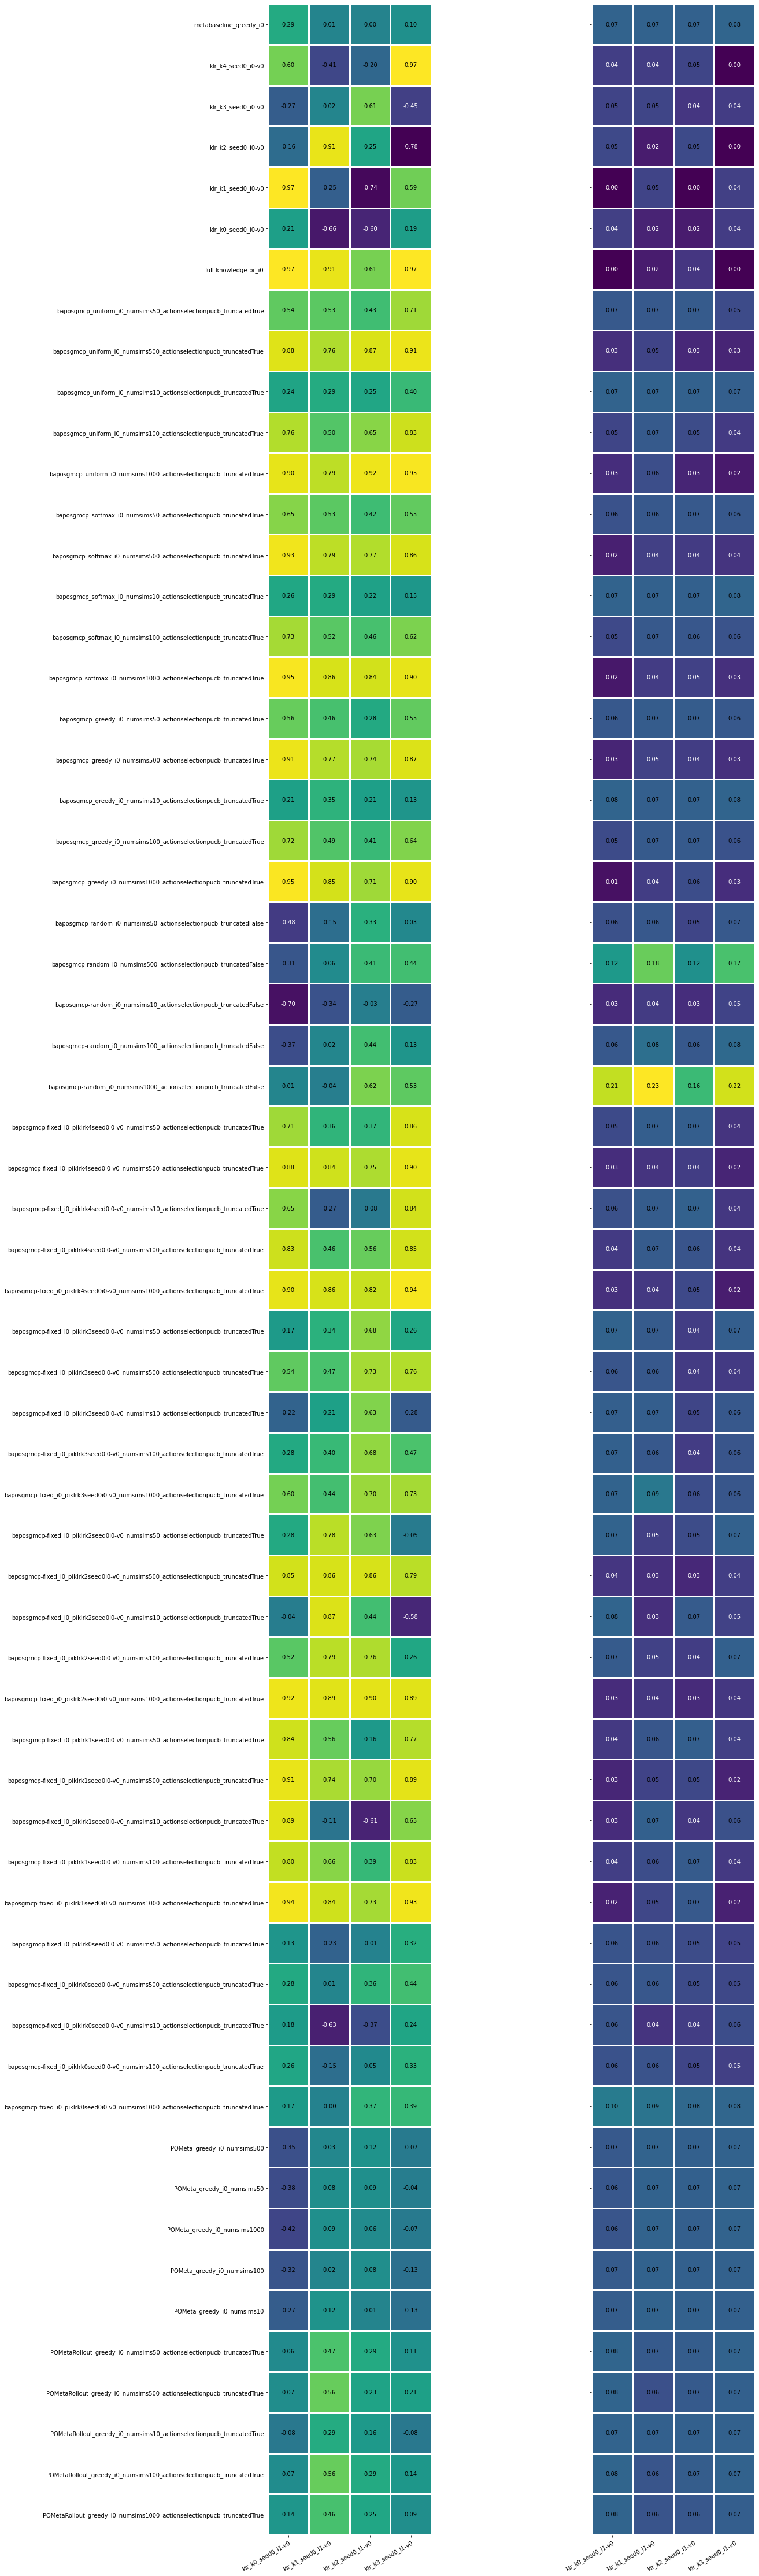

In [12]:
agent_0_df = combined_df[combined_df["agent_id"] == 0]
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1728x4464 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

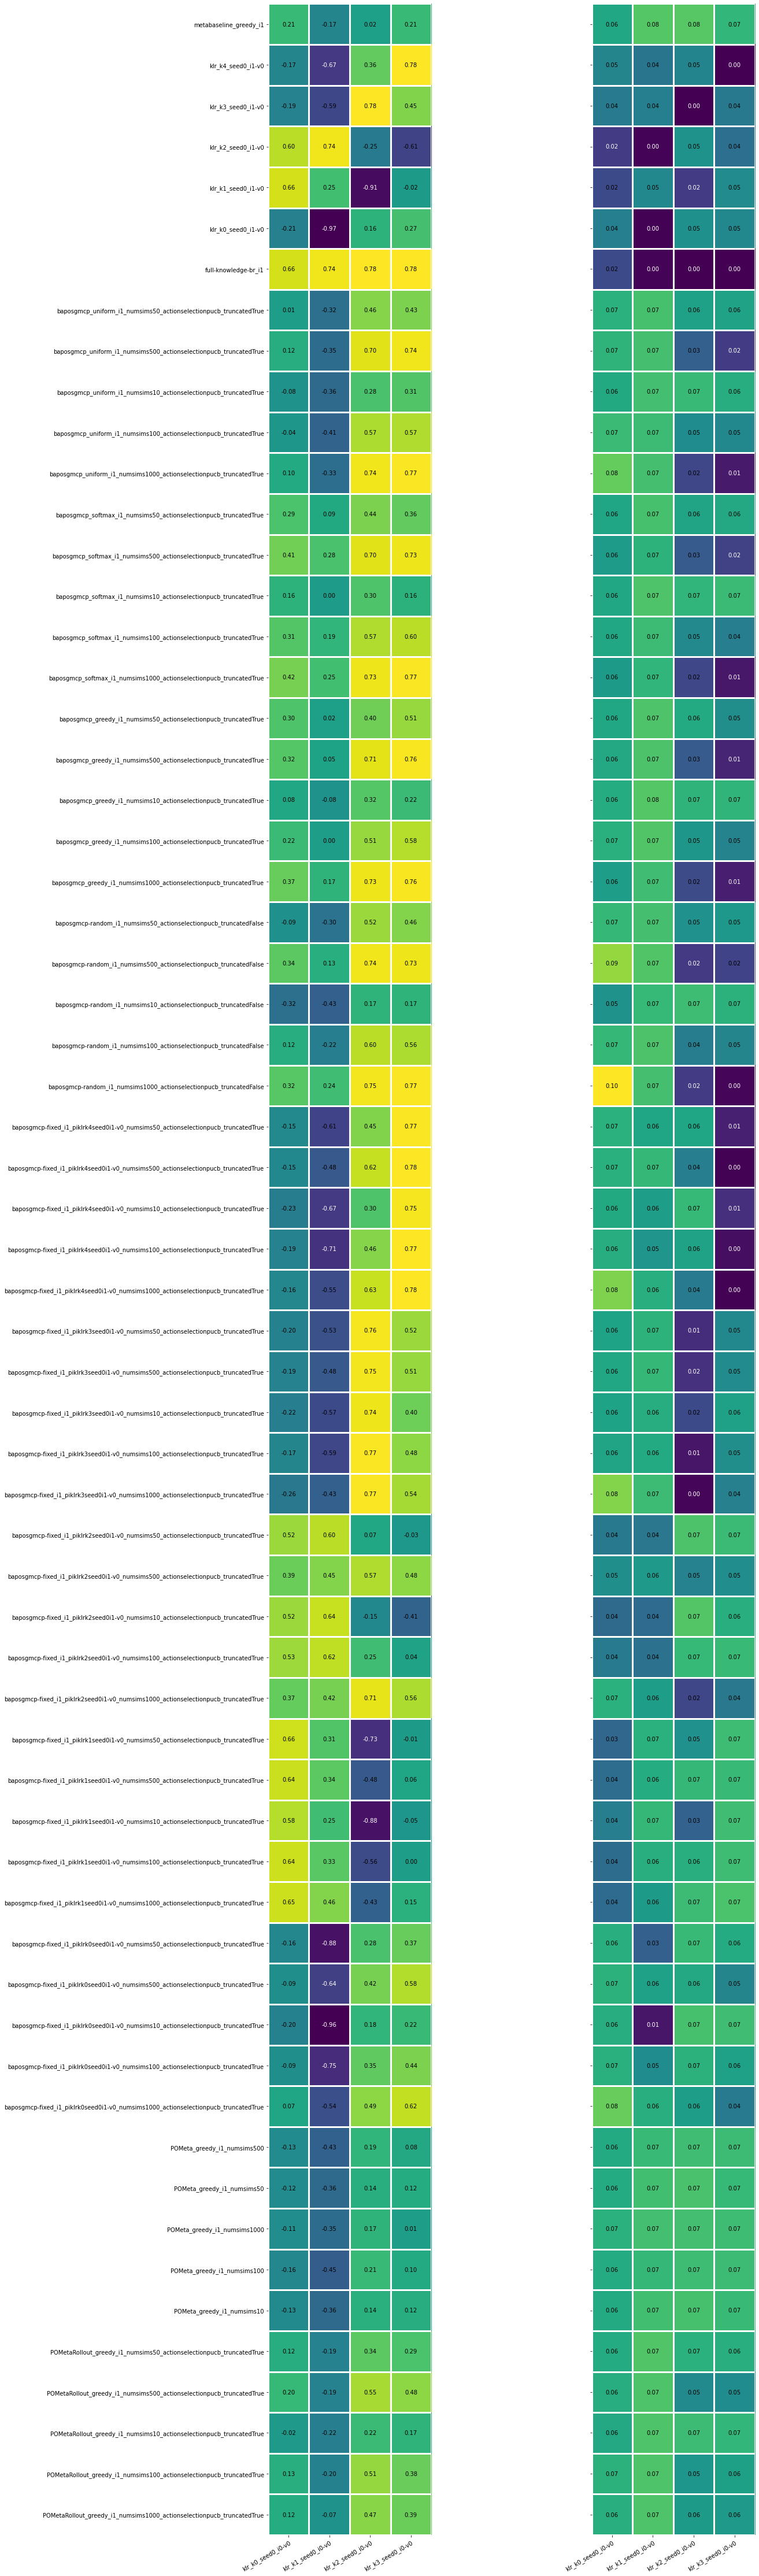

In [13]:
agent_1_df = combined_df[combined_df["agent_id"] == 1]
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_1_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1728x4464 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

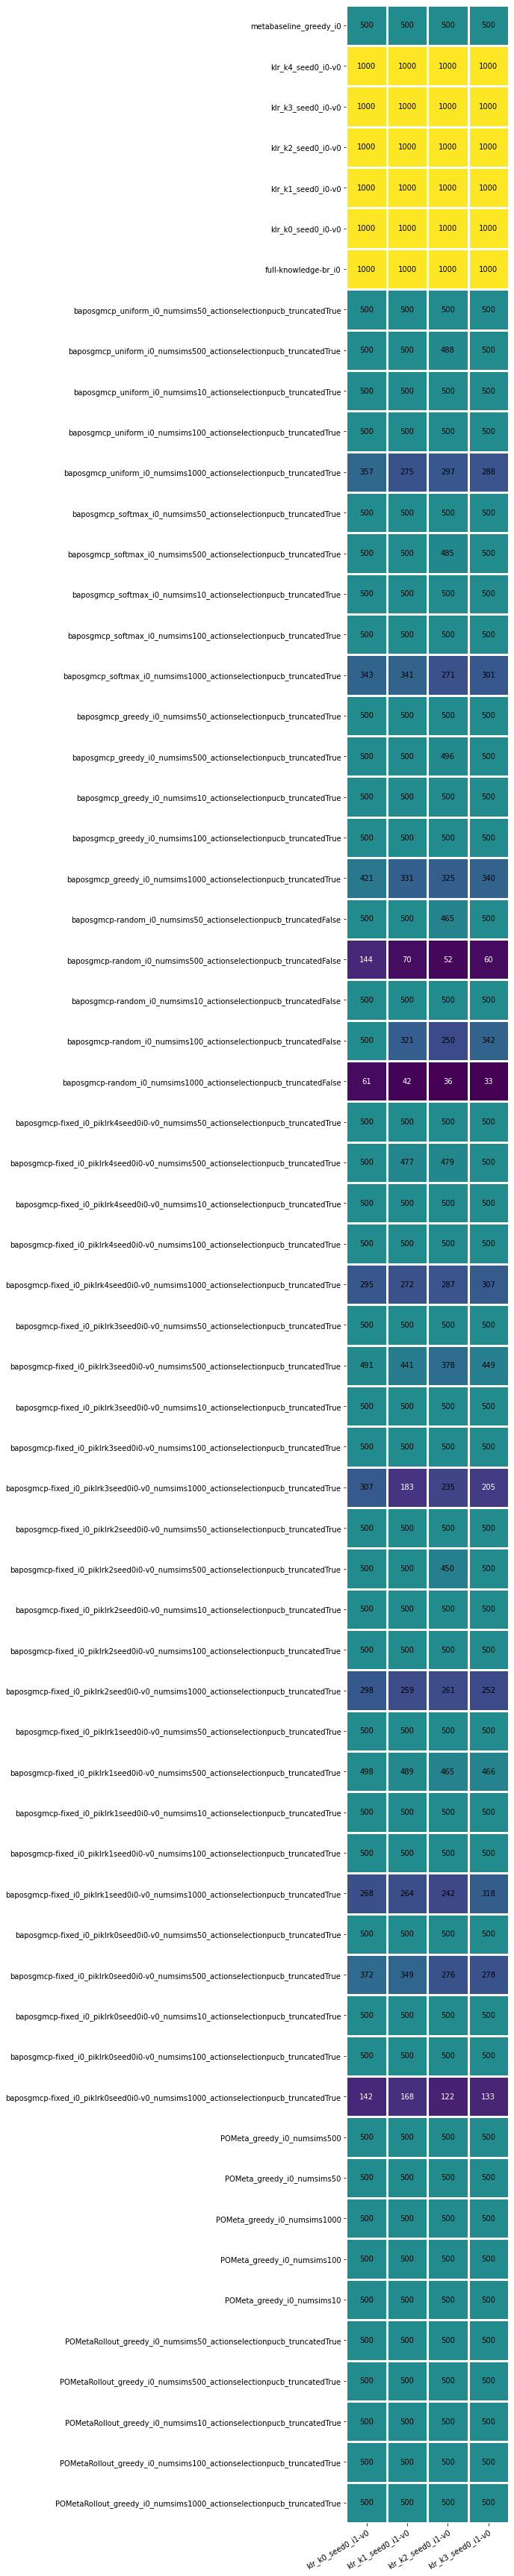

In [14]:
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1728x4464 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

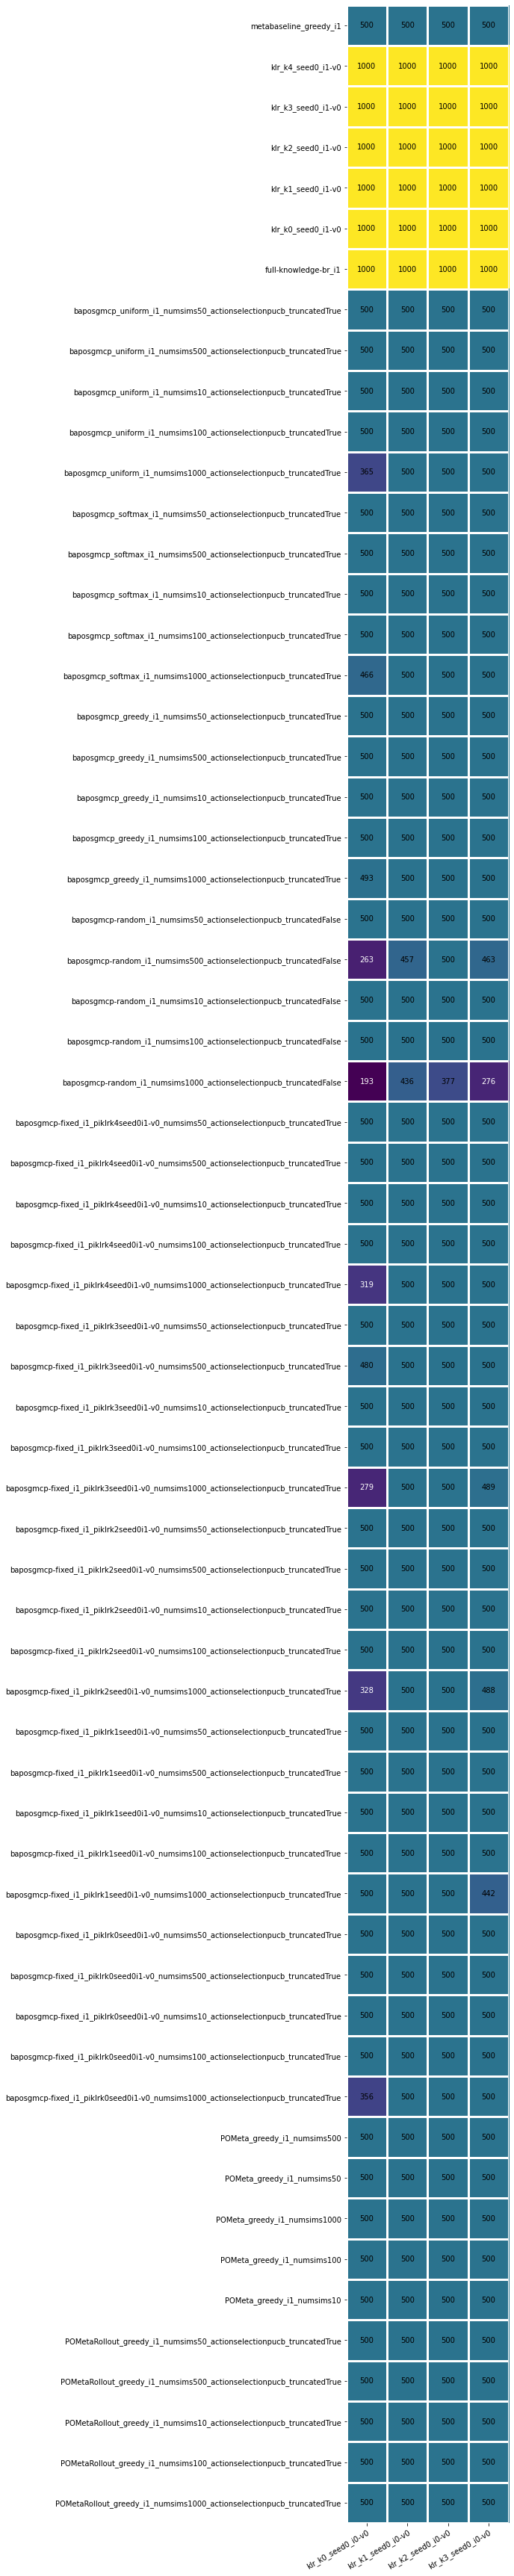

In [15]:
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, len(agent_1_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [16]:
exp_df = plot_utils.get_uniform_expected_df(combined_df, policy_prior)

Ungrouped size = 502
Grouped size = 124


In [17]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

### Action Selection

NA since used `action_selection=PUCB` where applicable for PursuitEvasion exps.

In [18]:
exp_df["action_selection"].unique()

array(['pucb', None], dtype=object)

### Comparison of truncation

NA since used `truncated=True` where applicable for PursuitEvasion exps.

In [19]:
exp_df["truncated"].unique()

array(['True', None, 'False'], dtype=object)

### Comparison of the different Meta-Policies

In [20]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    # (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline"]))
    (exp_df["alg_id"].isin(["baposgmcp"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_greedy_i0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i1_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i1_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i1_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i1_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_greedy_i1_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_softmax_i0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_softmax_i0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_softmax_i0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_softmax_i0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_softmax_i0_numsims50_actionse

agent_id=0
alg_id='baposgmcp'
agent_id=1
alg_id='baposgmcp'


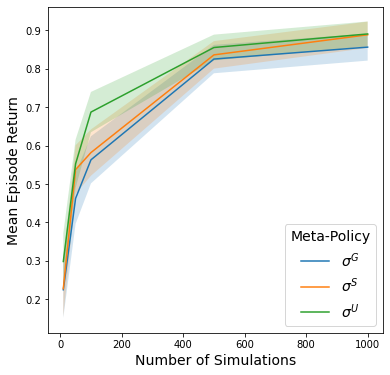

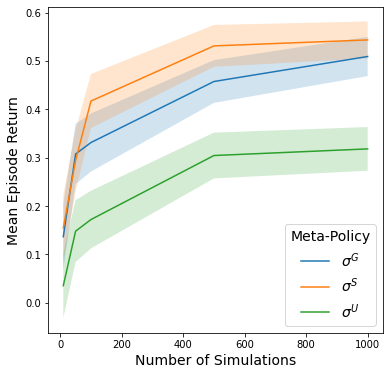

In [21]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": "lower right",
    "title": "Meta-Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    for alg_id in meta_alg_ids:
        print(f"{alg_id=}")
        fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
            meta_pi_df[(meta_pi_df["agent_id"] == agent_id) & (meta_pi_df["alg_id"] == alg_id)],
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            meta_pi_label_map=meta_pi_label_map,
            alg_id_key="alg_id",
            set_title=False,
            **plot_kwargs
        )
        fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}_i{agent_id}.png"))
    
del plot_kwargs

agent_id=0
alg_id='baposgmcp'
agent_id=1
alg_id='baposgmcp'


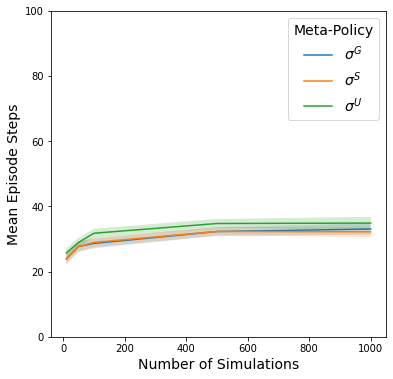

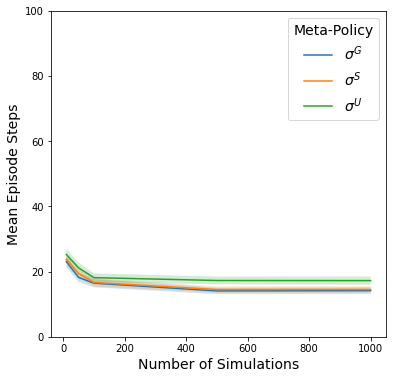

In [22]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0, 100),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper right',
    "title": "Meta-Policy",  
})
    
for agent_id in [0, 1]:
    print(f"{agent_id=}")
    for alg_id in meta_alg_ids:
        print(f"{alg_id=}")
        fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
            meta_pi_df[(meta_pi_df["agent_id"] == agent_id) & (meta_pi_df["alg_id"] == alg_id)],
            y_key="episode_steps_mean",
            y_err_key="episode_steps_CI",
            meta_pi_label_map=meta_pi_label_map,
            alg_id_key="alg_id",
            set_title=False,
            **plot_kwargs
        )
        fig.savefig(osp.join(figure_dir, f"meta_pi_steps_{alg_id}_i{agent_id}.png"))
    
del plot_kwargs

### Comparing Meta-Policy versus no meta-policy

In [23]:
# TODO May need to change BAPOSGMCP meta policy depending on results
# BAPOSGMCP Meta-Policy
# 0: Best = uniform (but only marginally at lower #sims (i.e. 100))
#           Performance is roughly equal between all meta Pis at higher sims >=500
# 1: Best = clearly softmax > greedy > uniform
#
# Hence I use softmax for remainder of analysis

meta_vs_no_pi_label_map = {
    0: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_softmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random_0",
        "baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
        "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "K2_0",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "K0_0",
        "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_softmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random_1",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "K0_1",
        "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "K2_1",
        "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        (exp_df["alg_id"] == "baposgmcp-random") | (exp_df["truncated"].isin([True, 'True', None]))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp-fixed_i

agent_id=0
agent_id=1


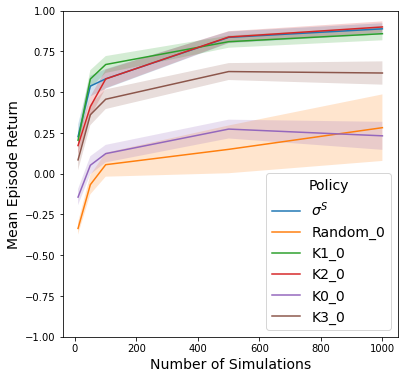

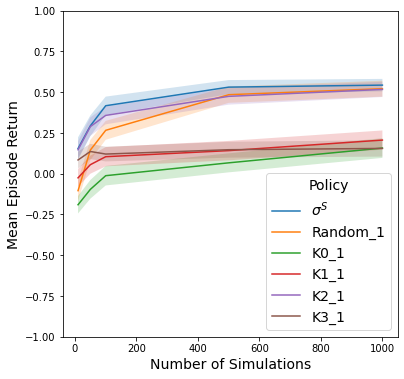

In [24]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_pi_label_map[agent_id],
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_i{agent_id}.png"))
    
del plot_kwargs

agent_id=0
agent_id=1


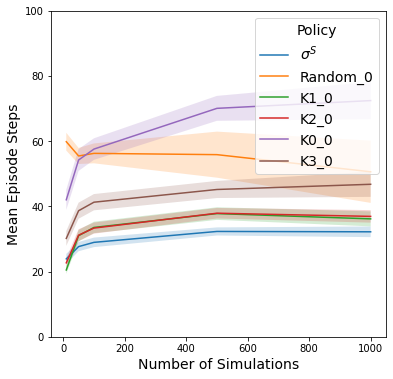

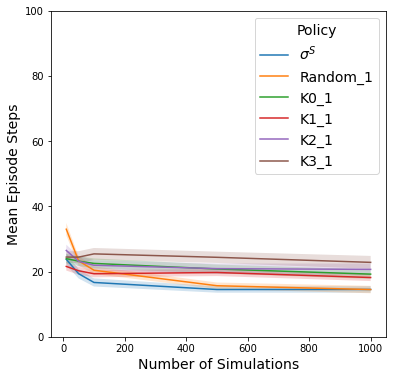

In [25]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0, 100),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
    "title": "Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        policy_prefixes=[list(meta_vs_no_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_pi_label_map[agent_id],
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_steps_i{agent_id}.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines



In [26]:
perf_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline", "full-knowledge-br"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

policy_prefixes_to_plot = [
    # "baposgmcp_uniform",
    "baposgmcp_softmax",
    "POMeta_greedy",
    "POMetaRollout_greedy",
    "metabaseline_greedy",
    "full-knowledge-br"
]

baseline_pi_label_map = {
    # "baposgmcp_uniform": "BAPOSGMCP",
    "baposgmcp_softmax": "BAPOSGMCP",
    "baposgmcp-random": "BAPOSGMCP Random",
    "POMeta_greedy": "POMeta", 
    "POMetaRollout_greedy": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
    "full-knowledge-br": "Best-Response"
}

agent_id=0
agent_id=1


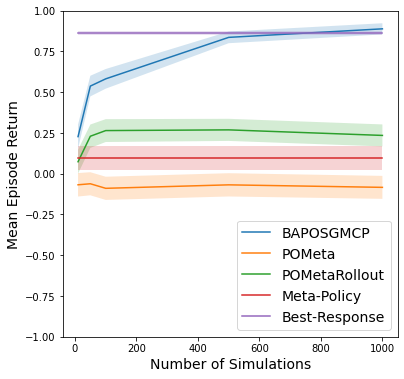

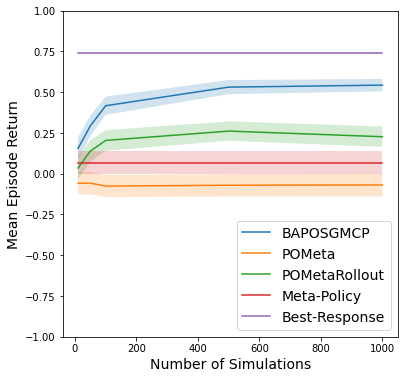

In [27]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
        perf_df[perf_df["agent_id"] == agent_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[policy_prefixes_to_plot],
        pi_label_map=baseline_pi_label_map,
        **plot_kwargs,
    )

    fig.savefig(osp.join(figure_dir, f"baselines_return_i{agent_id}.png"))
    
del plot_kwargs

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [29]:
belief_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', None]))
    & (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout"]))
    # & (exp_df["truncated"].isin([True]))
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "num_sims"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in belief_group_keys:
    if k in belief_agg_dict:
        belief_agg_dict.pop(k)
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["num_sims"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
print(belief_gb_df)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
Ungrouped size = 50
Grouped size = 15
           alg_id  num_sims  exp_id  exp_seed  coplayer_policy_id  agent_id  \
0          POMeta        10      64         0  klr_k0_seed0_i1-v0         0   
5   POMetaRollout        10      84         0  klr_k0_seed0_i1-v0         0   
10      baposgmcp        10       0         0  klr_k0_seed0_i1-v0         0   
1          POMeta        50      68         0  klr_k0_seed0_i1-v0         0   
6   POMetaRollout        50      88         0  klr_k0_seed0_i1-v0         0   
11      baposgmcp        50       4         0  klr_k0_seed0_i1-v0         0   
2          POMeta       100      72         0  klr_k0_seed0_i1-v0         0   
7   POMetaRollout       100      92         0  klr_k0_seed0_i1-v0         0   
12      baposgmcp       100       8         0  klr_k0_seed0_i1-v0         0   
3          POMeta       500      76         0  klr_k0_seed0_i1-v0         0   
8   POMetaRollout       500      96         0 

In [30]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    "title": "Num. Sims." 
})

alg_id='POMeta'
agent_id=0
agent_id=1
alg_id='POMetaRollout'
agent_id=0
agent_id=1
alg_id='baposgmcp'
agent_id=0
agent_id=1


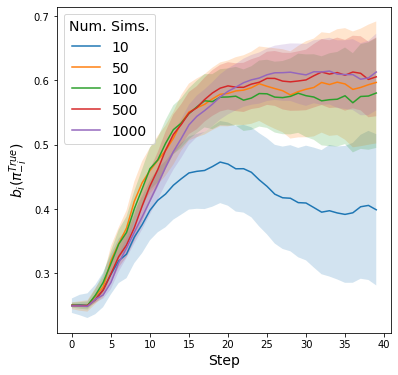

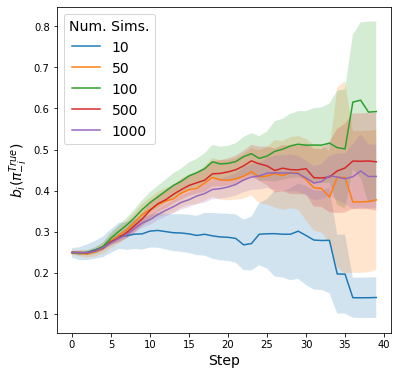

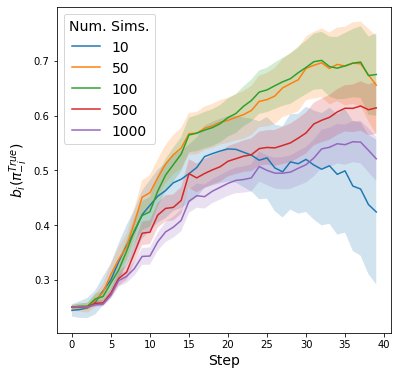

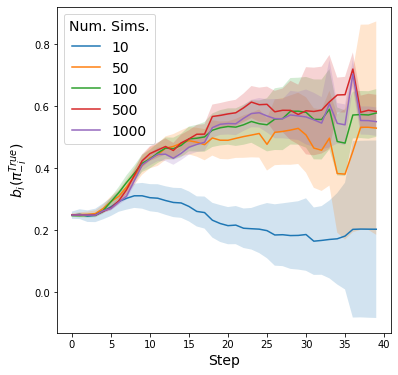

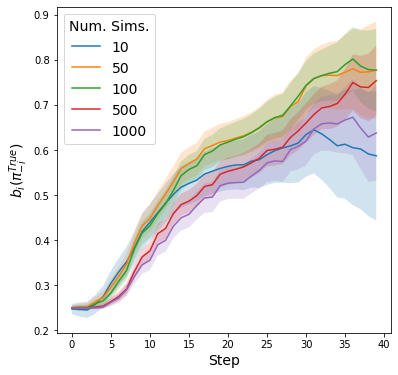

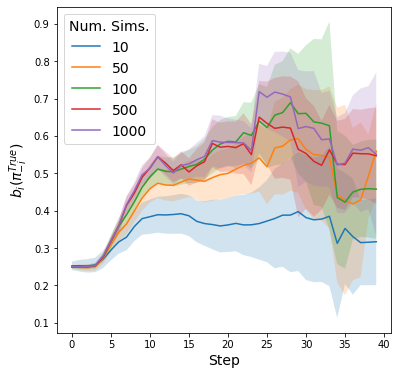

In [33]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r'$b_{i}(\pi_{-i}^{True})$'
    # "ylim": (1.5, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
})

for alg_id in belief_alg_ids:
    print(f"{alg_id=}")
    alg_df = belief_gb_df[belief_gb_df["alg_id"] == alg_id]
    for (i, j) in [(0, 1), (1, 0)]:
        print(f"agent_id={i}")
        fig, _ = plot_utils.paper.plot_multiple_belief_stats(
            alg_df,
            y_key_prefix="bayes_accuracy",
            step_limit=40,
            other_agent_id=j,
            y_suffix="mean",
            y_err_suffix="CI",
            alg_id_key="alg_id",
            **plot_kwargs
        )

        fig.savefig(osp.join(figure_dir, f"bayes_accuracy_{alg_id}_{i}.png"))
    
del plot_kwargs

alg_id='POMeta'
agent_id=0
agent_id=1
alg_id='POMetaRollout'
agent_id=0
agent_id=1
alg_id='baposgmcp'
agent_id=0
agent_id=1


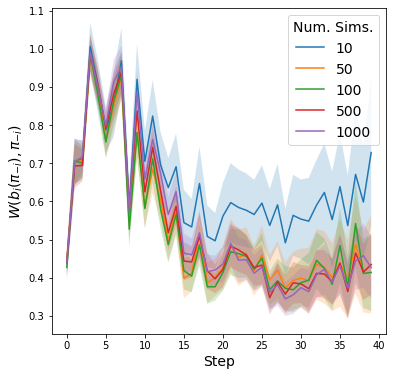

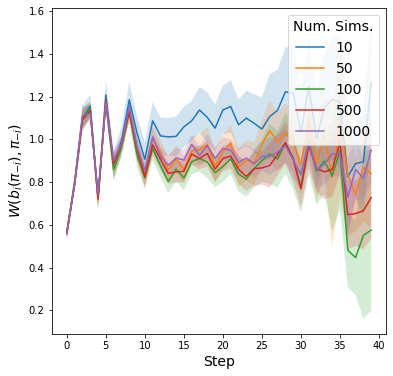

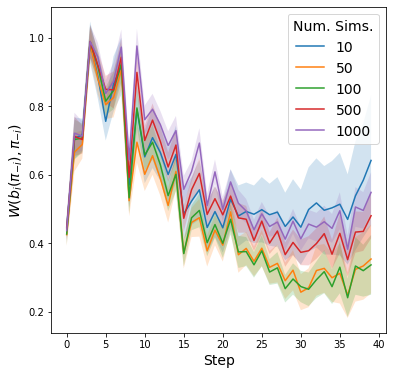

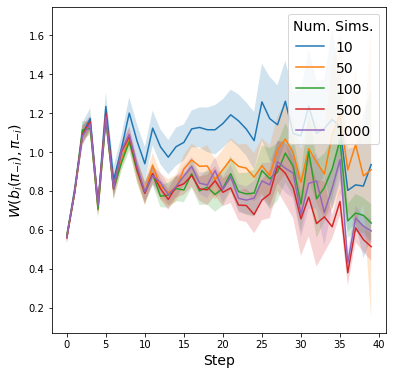

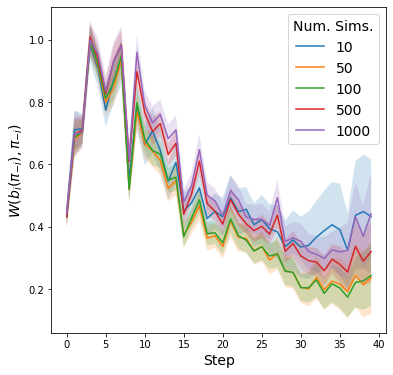

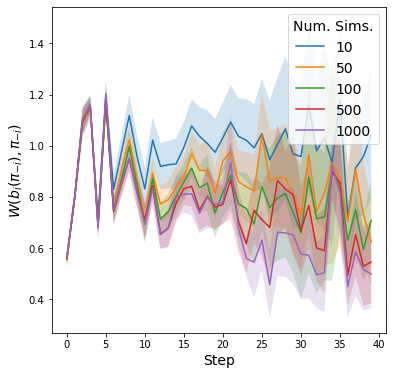

In [34]:
plot_kwargs = copy.deepcopy(belief_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylabel": r"$W(b_{i}(\pi_{-i}), \pi_{-i})$"
    # "ylim": (1.5, 2.3),
})

plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
})

for alg_id in belief_alg_ids:
    print(f"{alg_id=}")
    alg_df = belief_gb_df[belief_gb_df["alg_id"] == alg_id]
    for (i, j) in [(0, 1), (1, 0)]:
        print(f"agent_id={i}")
        fig, _ = plot_utils.paper.plot_multiple_belief_stats(
            alg_df,
            y_key_prefix="action_dist_distance",
            step_limit=40,
            other_agent_id=j,
            y_suffix="mean",
            y_err_suffix="CI",
            alg_id_key="alg_id",
            **plot_kwargs
        )

        fig.savefig(osp.join(figure_dir, f"action_dist_{alg_id}_{i}.png"))

    
del plot_kwargs

# Old stuff

Below has not been updated.

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [28]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

NameError: name 'policies_with_sims' is not defined

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

In [ ]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_times,
    policies_without_sims=[]
)

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [ ]:
policy_ids_by_alg = [
    ["baposgmcp_greedy_10", "baposgmcp_greedy_50", "baposgmcp_greedy_100", "baposgmcp_greedy_500", "baposgmcp_greedy_1000", "baposgmcp_greedy_2500"],
    ["baposgmcp_softmax_10", "baposgmcp_softmax_50", "baposgmcp_softmax_100", "baposgmcp_softmax_500", "baposgmcp_softmax_1000", "baposgmcp_softmax_2500"],
    ["baposgmcp_uniform_10", "baposgmcp_uniform_50", "baposgmcp_uniform_100", "baposgmcp_uniform_500", "baposgmcp_uniform_1000", "baposgmcp_uniform_2500"]
]

In [ ]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="bayes_accuracy",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(18, 9)
)

In [ ]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="action_dist_distance",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(18, 9)
)